In [ ]:
# pip install ml_metrics

In [4]:
# pip install catboost

In [15]:
# !pip install qgrid
# !jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [2]:
# !pip3 install ml_metrics

In [2]:
# !pip install mlxtend

In [36]:
# !pip install pandarallel

In [10]:
# !pip wheel . -w dist
# !pip install -U pip wheel setuptools

In [12]:
# !pip install lightautoml

In [3]:
import pandas as pd
import numpy as np

import warnings
import random
import gc

import tensorflow as tf
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
# import lightgbm as lgb
# import ml_metrics as mlm
import qgrid
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold


from sklearn.preprocessing import StandardScaler
# from  sklearn.metrics.pairwise import pairwise_distances
# from  sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import pickle

import multiprocessing
from multiprocessing import Pool

from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
warnings.simplefilter("ignore")

In [4]:
df_products = pd.read_csv('products.csv')
df_transactions = pd.read_csv('transactions.csv')

## Discussing the task

Можно разделить задачу на два составляющие:

    1. Как можно точнее определить какие продукты клиент перезакажет в новом заказе.
    2. Добавить продукты, которых может не быть в истории покупок пользователя, но которые он может купить в следующий раз. Что заказывают пользователи, похожие на текущего. Что заказывают с товаром, который часто перезаказывает текущий клиент(ассоциативные правила).

## Preparing data, manage features

In [4]:
client_basket = df_transactions.groupby('user_id').apply(lambda x: x[x.order_number == x.order_number.max()])
client_basket = client_basket.reset_index(drop= True)

**Посчитаем процент продуктов, перезаказанных пользователями по отношению к общему количеству уже заказанных продуктов**

In [5]:
# Сколько продуктов купил клиент
total_unique_products = df_transactions[['user_id', 'product_id']].groupby('user_id').agg('count')
total_unique_products = total_unique_products.rename(columns = {'product_id': 'total_products'})
# Сколько перезаказано 
reord = df_transactions.groupby('user_id').agg(sum)['reordered']
reord = total_unique_products.merge(reord, on = 'user_id')
reord['ratio'] = reord['reordered']/reord['total_products']
avd_percent = reord['ratio'].sum()/len(reord)
min_reord = reord['ratio'].min()
max_reord = reord['ratio'].max()

print(f'Средний процент перезаказанных товаров по всем заказам: {avd_percent}')
print(f'Минимальный процент перезаказанных товаров по всем заказам: {min_reord}')
print(f'Максимальный процент перезаказанных товаров по всем заказам: {max_reord}')

Средний процент перезаказанных товаров по всем заказам: 0.5684645937617683
Минимальный процент перезаказанных товаров по всем заказам: 0.0
Максимальный процент перезаказанных товаров по всем заказам: 0.9895287958115183


In [6]:
print('Сколько пользователей, которые вообще не повтоятся в заказах',( reord[reord['ratio'] == 0].count())[0])
print('Сколько пользователей, которые почти полностью повторяют заказы', (reord[reord['ratio'] >= 0.9].count())[0])

Сколько пользователей, которые вообще не повтоятся в заказах 1
Сколько пользователей, которые почти полностью повторяют заказы 669


**Посчитаем процент перезаказанных продуктов по отношению о остальным продуктам в текущем заказе**

In [7]:
reord_bask = client_basket.groupby('user_id').agg('sum')['reordered']
reord_bask = client_basket.groupby('user_id').agg('count').iloc[:,:1].merge(reord_bask, on = 'user_id')
reord_bask['ratio'] = reord_bask['reordered']/reord_bask['order_id']
avd_percent = reord_bask['ratio'].sum()/len(reord_bask)
min_reord = reord_bask['ratio'].min()
max_reord = reord_bask['ratio'].max()

print(f'Средний процент перезаказанных товаров в последних заказах: {avd_percent}')
print(f'Минимальный процент перезаказанных товаров в последних заказах: {min_reord}')
print(f'Максимальный процент перезаказанных товаров в последних заказах: {max_reord}')

Средний процент перезаказанных товаров в последних заказах: 0.7033680672440027
Минимальный процент перезаказанных товаров в последних заказах: 0.0
Максимальный процент перезаказанных товаров в последних заказах: 1.0


In [8]:
print('Процент пользователей, которые не повторили последний заказ',( reord_bask[reord_bask['ratio'] == 0].count()/100000)[0])
print('Процент пользователей, которые полностью повторили последний заказ', (reord_bask[reord_bask['ratio'] == 1].count()/100000)[0])

Процент пользователей, которые не повторили последний заказ 0.0317
Процент пользователей, которые полностью повторили последний заказ 0.24177


_______________________

Посмотрим наименьшее количество заказов (самые короткие истории заказов). Проверим нет ли пользователей без истории.

In [147]:
df_hst = df_transactions.groupby('user_id')['order_number'].agg('max').reset_index().sort_values(by = 'order_number')
df_hst.head(1)

,user_id,order_number
14443,29935,9


Посмотрим распределение по количеству заказов

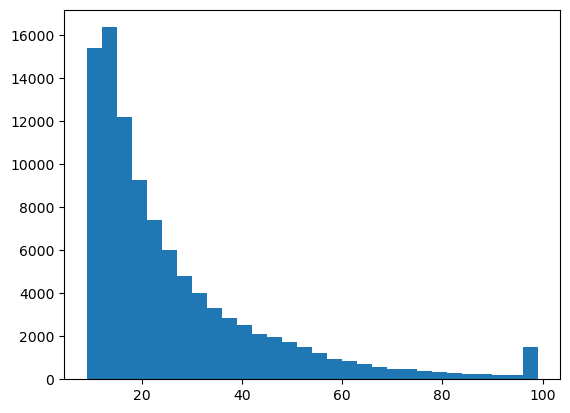

In [40]:
plt.hist(df_hst['order_number'], bins = 30)
plt.show()

_______
По данным видно что наименьшая история равна 9 заказам. По данной истории можно также анализировать предпочтения. Пользователей с 1 заказом нет.
Большинство сделали до 20 заказов.
Также есть группа, которая уже сделала около 100 заказов. 

### Number orders of the product by user in history

In [5]:
df_re = df_transactions[['user_id', 'order_id', 'order_number', 'product_id', 'reordered']]

Гипотетически если продукты были заказаны наибольшее количество раз пользователем, то он вероятнее закажет их опять. 
Поэтому одним признаком для обучения возьмем количество покупок продукта в истории пользователя

In [5]:
num_prod_hist = df_re.groupby(['user_id', 'product_id']).agg('count')['order_number'].reset_index()
num_prod_hist = num_prod_hist.rename(columns = {'order_number':'tot_purchases'})
df_re = df_re.merge(num_prod_hist, how = 'left', on = ['user_id', 'product_id']).fillna(0)

 ### Weight

Также если в прошлом пользователь покупал продукт, но потом перестал, то вряд ли он его купит в следующем заказе.
Поэтому добавим вес, чтобы новые заказы по продукты были более важны.

In [6]:
# 2. Last order number of a product ordered by a client
max_order_prod_usr = df_re[['user_id', 'order_number']].groupby('user_id').agg('max')
max_order_prod_usr = max_order_prod_usr.rename(columns = {'order_number': 'max_order'})
df_re = df_re.merge(max_order_prod_usr, how = 'left', on = 'user_id').fillna(0)

In [7]:
df_re['weight'] = df_re.order_number/df_re.max_order

In [8]:
df_re['weight_cum'] = df_re.groupby(['user_id', 'product_id'])['weight'].cumsum()

In [9]:
df_re.drop(columns = (['max_order', 'weight']), axis = 1, inplace = True)

In [10]:
df_re.head()

,user_id,order_id,order_number,product_id,reordered,weight_cum
0,1,2539329,1,196,0.0,0.1
1,1,2539329,1,14084,0.0,0.1
2,1,2539329,1,12427,0.0,0.1
3,1,2539329,1,26088,0.0,0.1
4,1,2539329,1,26405,0.0,0.1


### Association rules

Построение ассоциаивных правил (что с чем покупают) строится на основных понятиях:

   **Поддержка** - совокупность всех операция с продуктами A и B/ все транзакции
    
   **Уверенность** - все транзакции с продуктами A и B/ все транзакции с A 

Добавим ассоциативные правила. Какие продукты часто покупаются вместе.

In [4]:
import mlxtend
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

Посмотрим на распределение количества покупок продуктов

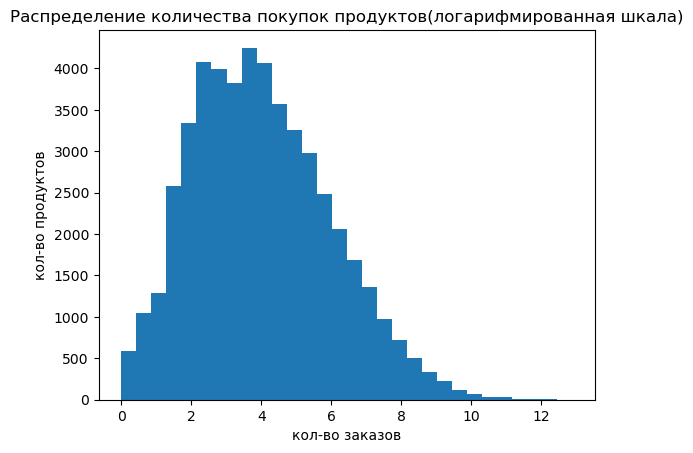

In [5]:
cnt_prod = df_transactions[['order_id', 'product_id']].groupby('product_id').agg('count').sort_values(by = 'order_id')
plt.hist(np.log(cnt_prod), bins = 30)
plt.title('Распределение количества покупок продуктов(логарифмированная шкала)')
plt.xlabel('кол-во заказов')
plt.ylabel('кол-во продуктов')
plt.show()

Есть значительная часть продуктов, которые заказали мало раз. 
Уберем продукты, котрые заказали менее 25 раз

In [6]:
cnt_prod = cnt_prod[cnt_prod['order_id'] >= 25]

подготовим датасет, сделаем список продуктов по каждому заказу

In [7]:
data_asc_rules = list(df_transactions[df_transactions['product_id'].isin(cnt_prod.index)].groupby(['user_id', 'order_number'])['product_id'].apply(list))  

In [11]:
len(data_asc_rules)

867416.3333333334

#### Apriori Algorithm

**Алгоритм apyori, написанный Ю Мочизуки (Yu Mochizuki)** https://github.com/ymoch/apyori

In [7]:
from apyori import apriori

In [ ]:
%%time
result = list(apriori(data_asc_rules, min_support = 0.001, min_confidence = 0.1, min_lift = 4, min_length = 2, max_legth = 5))

In [ ]:
# Вспомогательный датасет с ассоциативными правилами
output = []
for RelationRecord in result:
    o = list(RelationRecord[0])
#     support = RelationRecord[1]
    output.append(o)
df_ar = pd.DataFrame(output)

In [ ]:
# Посмотрим, какие сеты нашлись:
df_ar['product_1'] = df_ar[0].map(df_products.product_name)
df_ar['product_2'] = df_ar[1].map(df_products.product_name)
df_ar['product_3'] = df_ar[2].map(df_products.product_name)
df_ar['product_4'] = df_ar[3].map(df_products.product_name)
df_ar.head()

In [ ]:
df_ar.tail()

По данным видно, что вместе заказывают наборы для приготовления (например рыбу и заправки к ней), несколько итальянских продуктов, несколько видов напитков (возможно для коктейлей), несколько видов супов, "студенческие наборы" (снеки плюс канцелярия)

### Collaborative filtering(user_based)

Чтобы реализовать второй пункт в задаче и дополнить предсказание, найдем похожих пользователей и продукты, которых нет в сете текущего пользователя. В качестве "рейтнга" будем использовать число покупок товара пользователем

In [11]:
mtrx = df_re[['user_id', 'product_id', 'order_number']].groupby(['user_id', 'product_id']).agg('count').reset_index()

In [12]:
def pivotSegment(lst_usr,passedFrame):
    """Функция, делающая pivot, в результате получаем разреженную матрицу"""
    frame = passedFrame[passedFrame.user_id.isin(lst_usr)]
    
   # добавляем нулевого пользователя с размером столбцов, равным все продуктам
    span = pd.DataFrame() 
    span['product_id'] = [i for i in mtrx.product_id.unique()]
    span['user_id'] = 0
    span['order_number']=0

    frame = frame.append(span)
    frame = frame.pivot(values = 'order_number',index= 'user_id',columns='product_id').fillna(0).astype('int8')
    # отрезаем нулевого пользователя
    frame = frame[frame.index != 0] 
    return frame

In [13]:
%%time
pvt_df = pd.DataFrame()
users = mtrx.user_id.unique()
# Берем батчи по 5000 пользователей, чтобы не было ошибок с памятью
for i in range(0, 100000, 5000):
    lst_usr = users[i:i+5000]
    mini_df = pivotSegment(lst_usr, mtrx)
    pvt_df = pvt_df.append(mini_df)
    gc.collect()

Wall time: 6min 30s


In [9]:
%%time
# список алгоритмов
alhs = []
for i in range(0, len(pvt_df), 10000):
    # создаем и обучаем алгоритм
    nbrs = NearestNeighbors(n_neighbors=3)
    nbrs.fit(pvt_df.iloc[i:i+10000])
    # разбиваем датасет на несколько и делаем соответственно список KNN моделей
    alhs.append(nbrs)

Wall time: 7min 9s


In [20]:
# import fillingdf

In [10]:
KNN_dataset = pd.DataFrame()
KNN_dataset['user_id'] = mtrx.user_id.unique()
KNN_dataset['top1'] = ''
KNN_dataset['top2'] = ''

In [8]:
def get_sim_n_usr(usrs):
    """функция находит ближайшего соседа из всех предобученных можелей KNN и заполняет таблицу
    KNN_dataset - таблица для всех пользователей и их ближайших топ-2 соседей
    pvt_df - разряженная матрица вида юзер*продукт*количество куплено
    alhs - список с предобученными на батчах алгоритмами"""
    for en, usr_id in enumerate(usrs):
        distances = []
        indices = []
        for j in range(len(alhs)):
            vals = alhs[j].kneighbors(pvt_df[pvt_df.index == usr_id])
            distances.extend(vals[0][0])
            indices.extend(vals[1][0])
        # удаляем самого юзера
        distances.pop(0)
        indices.pop(0)
        # dst_min = np.argsort(distances)[:2]

        KNN_dataset['top1'].iloc[en] = indices[0]
        KNN_dataset['top2'].iloc[en] = indices[1]

        print('finished sleeping @ ', dt.datetime.now())

In [1]:
if __name__ == '__main__':
    pool = multiprocessing.Pool(8)
    pool.map(get_sim_n_usr, (users[:8]))

KNN_dataset.to_csv('collaborative_filtering.csv')

In [40]:
# Пример заполнения датасета
KNN_dataset.head(10)

,user_id,top1,top2
0,1,5010,9291
1,2,765,7571
2,3,8448,2841
3,7,6586,4940
4,13,673,8574
5,14,3676,7103
6,15,8573,5010
7,17,8108,5699
8,21,,
9,22,,


### Коэффициэнт сходства Пирсона

$$r_{xy}=\frac{(x_i - avg_x)(y_i - avg_y)}{\sqrt{(x_i - avg_x)^2(y_i - avg_y)^2}}$$

In [15]:
def pearson(pvt_df, fir_usr, sec_usr):
    if fir_usr in users and fir_usr in users:
        fir_sum = pvt_df[pvt_df.index == fir_usr].values.sum()
        fir_len = len(pvt_df[pvt_df.index == fir_usr].values[0])
        fir_usr_avg = fir_sum/fir_len
        
        sec_sum = pvt_df[pvt_df.index == sec_usr].values.sum()
        sec_len = len(pvt_df[pvt_df.index == sec_usr].values[0])
        sec_usr_avg = sec_sum/sec_len
        
        fir_keys = set(mtrx[mtrx.user_id == fir_usr]['product_id'].unique())
        sec_keys = set(mtrx[mtrx.user_id == sec_usr]['product_id'].unique())
        
     # union of two sets
        all_items = (fir_keys|sec_keys)
        dividend = 0
        divisor_a = 0
        divisor_b = 0
        
        # normalisation by substracting average
        for i in all_items:
            nr_a = (pvt_df[pvt_df.index == fir_usr][i] - fir_usr_avg).values[0]
            nr_b = (pvt_df[pvt_df.index == sec_usr][i] - sec_usr_avg).values[0]
            dividend += (nr_a) * (nr_b)
            
            divisor_a += pow(nr_a, 2)
            divisor_b += pow(nr_b, 2)
        
        divisor = np.sqrt((divisor_a)*(divisor_b))
        if divisor != 0:
            return dividend / divisor
        
        return 0

In [18]:
%%time
pearson(pvt_df, 1, 7)

Wall time: 1.39 s


0.005232994195751078

### Коэффициэнт сходства Жаккара

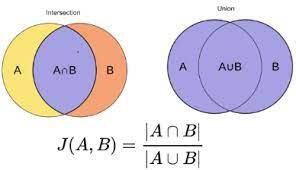

$$J = \frac{UsersBoughtBothProducts}{UsersBoughtEither1or2}$$

In [16]:
def jaccard(pvt_df, fir_usr, sec_usr):
    if fir_usr in users and sec_usr in users:
        # вычисляем пересечение между пользователями
        intersect = set(pvt_df[pvt_df.index == fir_usr].values[0])&set(pvt_df[pvt_df.index == sec_usr].values[0])
        
        union = set(pvt_df[pvt_df.index == fir_usr].columns)|set(pvt_df[pvt_df.index == sec_usr].columns)
        
        return len(intersect)/int(len(union))
    else:
        return 0

In [17]:
%%time
jaccard(pvt_df, 1, 3)

Wall time: 4.74 s


0.00012129788739512787

### Реализация похожести пользователей

In [19]:
def similar_users(pvt_df, user, type):
    # Сбор оценок(количество покупок) текущего пользователя
    max_sim_usr = 0
    s_cur = 0
    similarity = dict()
    switcher = {
        'jaccard':jaccard,
        'pearson':pearson,
    }
    for en, user_id in enumerate(pvt_df.index):
        func = switcher.get(type)
        s = func(pvt_df, user, user_id)
        if s > 0.5 and user_id != user:
            if s > s_cur:
                max_sim_usr = user_id
                s_cur = s    
    return max_sim_usr

In [21]:
# %%time
# max_sim_usr = similar_users(pvt_df, 1, 'pearson')
# max_sim_usr

In [169]:
# %%time
# similar_users(pvt_df, 1, 'jaccard')

### Train_test split

Так как задача предсказать следующий заказ, то тренировочные, тестовые и валидационные данные нужно разбить в соответствии с номерами заказов.

In [11]:
client_basket_ = df_transactions.groupby('user_id').apply(lambda x: x[x.order_number == x.order_number.max()])[['user_id', 'product_id']].reset_index(drop = True)
client_previous_ = df_transactions.groupby('user_id').apply(lambda x: x[x.order_number == x.order_number.max()-1])['order_id']

In [12]:
cl_b = df_re[df_re.order_id.isin(client_previous_)]
cl_b = cl_b.groupby(['user_id','order_id','order_number','product_id','reordered']).agg('max').reset_index()
cl_b = cl_b.merge(client_basket_.groupby('user_id').agg(list).rename(columns = {'product_id': 'basket'})  , on = 'user_id')

In [13]:
cl_b['is_in_cur_basket'] = 0

In [14]:
for i in range(len(cl_b)):
    if cl_b['product_id'].iloc[i] in (cl_b['basket'].iloc[i]):
        cl_b['is_in_cur_basket'].iloc[i] = 1

In [15]:
cl_b.drop(['order_id', 'reordered', 'basket'], axis = 1, inplace = True)

In [18]:
cl_b.head()

,user_id,order_number,product_id,weight_cum,is_in_cur_basket
0,1,9,196,4.5,1
1,1,9,10258,4.4,1
2,1,9,12427,4.5,1
3,1,9,25133,4.2,1
4,1,9,46149,1.7,1


In [44]:
X_train, X_test, y_train, y_test = train_test_split(cl_b.loc[:, cl_b.columns != 'is_in_cur_basket'], cl_b['is_in_cur_basket'], test_size=0.33, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [45]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(717679, 4) (717679,)
(236834, 4) (236834,)
(116651, 4) (116651,)


In [98]:
# To_add calss_weight
print(y_train.sum())
print(717679-207946)
print('1:', 207946/717679)
print('0:', 509733/717679)

207946
509733
1: 0.28974792351455175
0: 0.7102520764854482


## Metrics

In [81]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import ml_metrics as mlm

In [15]:
def get_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [16]:
def get_precision(y_true, y_pred):
    return precision_score(y_true, y_pred)

In [17]:
def get_auc_roc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

In [40]:
def Avg_Precision_at_n(df, n):
    apk_list = [] 
    usrs_list = df.user_id.unique()
    for i in usrs_list:
        list_of_orders = df[df['user_id'] == i]['order_number'].unique()
        for j in list_of_orders:
            apk = mlm.apk(
                list(df[(df['user_id'] == i)&(df['order_number'] == j)]['product_id']),
                list(df[(df['user_id'] == i)&(df['order_number'] == j)&(df['prob']>0.4)].sort_values(by = 'prob', ascending = False)['product_id']), n)
            apk_list.append(apk)
    return apk_list

In [19]:
def MAP_at_n(df, n):
    apk_list = Avg_Precision_at_n(df, n)
    return sum(apk_list)/len(apk_list)

In [35]:
def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                df,
                name: str = None):
    """Genegating table with metrics"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    cv_predicts = pd.DataFrame(np.zeros((5, 4)), columns = {'accuracy', 'precision', 'auc_roc', 'MAP@n'})
    kf = KFold(n_splits=5)
    for i, ids in enumerate(kf.split(y_test)):  
    #  Берем по 1000-5000 строк, чтобы быстрее посчитать 
        cv_predicts['accuracy'].iloc[i] = get_accuracy(y_pred[ids[1][0]:ids[1][5000]], y_pred[ids[1][0]:ids[1][5000]])      
        cv_predicts['precision'].iloc[i] = get_accuracy(y_pred[ids[1][0]:ids[1][5000]], y_pred[ids[1][0]:ids[1][5000]])
        cv_predicts['auc_roc'].iloc[i] = get_accuracy(y_pred[ids[1][0]:ids[1][5000]], y_pred[ids[1][0]:ids[1][5000]])
        cv_predicts['MAP@n'].iloc[i] = MAP_at_n(df.iloc[ids[1][0]:ids[1][5000]], n = 10)  
        
    df_metrics['accuracy'] = np.mean(cv_predicts['accuracy'])
    df_metrics['precision'] = np.mean(cv_predicts['precision'])
    df_metrics['auc_roc'] = np.mean(cv_predicts['auc_roc'])
    df_metrics['MAP@n'] = np.mean(cv_predicts['MAP@n'])

    return df_metrics

In [28]:
def check_overfitting(model, X_train, y_train, X_test, y_test, metric):
    """
    Check for overfitting
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mae_train = metric(y_train, y_pred_train)
    mae_test = metric(y_test, y_pred_test)

    print(f'{metric.__name__} train: %.3f' % mae_train)
    print(f'{metric.__name__} test: %.3f' % mae_test)
    print(f'delta = {(abs(mae_train - mae_test)/mae_train*100):.1f} %')

## Modeling

### Baseline

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
lr=LogisticRegression(C=10,n_jobs=1,max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, n_jobs=1)

In [37]:
y_pred = lr.predict(X_test)

In [38]:
# X_test.drop('prob', axis = 1, inplace = True)
X_test['prob'] = lr.predict_proba(X_test)[:,1]

In [41]:
%%time
metrics = get_metrics(y_test, y_pred, X_test, 'LinearRegression_baseline')
metrics

Wall time: 2min 10s


,model,accuracy,precision,auc_roc,MAP@n
0,LinearRegression_baseline,1.0,1.0,1.0,0.422514


In [65]:
X_test.drop('prob', axis = 1, inplace = True)

In [29]:
check_overfitting(lr,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric=precision_score)

precision_score train: 0.669
precision_score test: 0.668
delta = 0.1 %


### KNeighborsClassifier

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
clf = KNeighborsClassifier(n_neighbors = 10)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [43]:
y_pred = clf.predict(X_test)

In [44]:
# test.drop('prob', axis = 1, inplace = True)
X_test['prob'] = clf.predict_proba(X_test)[:,1]

In [45]:
%%time
metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'KNeighborsClassifier'))
metrics

Wall time: 2min 13s


,model,accuracy,precision,auc_roc,MAP@n
0,LinearRegression_baseline,1.0,1.0,1.0,0.422514
0,KNeighborsClassifier,1.0,1.0,1.0,0.335869


In [122]:
check_overfitting(clf,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric=precision_score)

precision_score train: 0.637
precision_score test: 0.371
delta = 41.8 %


### DecisonTreeClassifier

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [50]:
y_pred = tree.predict(X_test)

In [51]:
# test.drop('prob', axis = 1, inplace = True)
X_test['prob'] = tree.predict_proba(X_test)[:,1]

In [52]:
metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'DecisonTreeClassifier'))
metrics

,model,accuracy,precision,auc_roc,MAP@n
0,LinearRegression_baseline,1.0,1.0,1.0,0.422514
0,KNeighborsClassifier,1.0,1.0,1.0,0.335869
0,DecisonTreeClassifier,1.0,1.0,1.0,0.288131


In [129]:
check_overfitting(tree,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric=precision_score)

precision_score train: 1.000
precision_score test: 0.482
delta = 51.8 %


### RandomForestClassifier

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
rfcl=RandomForestClassifier(n_estimators=20,max_depth=15,class_weight={0:1,1:5},random_state=42,n_jobs=8)
rfcl.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 5}, max_depth=15, n_estimators=20,
                       n_jobs=8, random_state=42)

In [56]:
y_pred = rfcl.predict(X_test)

In [57]:
# test.drop('prob', axis = 1, inplace = True)
X_test['prob'] = rfcl.predict_proba(X_test)[:,1]

In [58]:
metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'RandomForestClassifier'))
metrics

,model,accuracy,precision,auc_roc,MAP@n
0,LinearRegression_baseline,1.0,1.0,1.0,0.422514
0,KNeighborsClassifier,1.0,1.0,1.0,0.335869
0,DecisonTreeClassifier,1.0,1.0,1.0,0.288131
0,RandomForestClassifier,1.0,1.0,1.0,0.727397


In [141]:
check_overfitting(rfcl,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric=precision_score)

precision_score train: 0.418
precision_score test: 0.410
delta = 2.1 %


In [72]:
pkl_filename = 'rfc.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(rfcl, file)

### LGBMClassifier

In [42]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [117]:
lg = LGBMClassifier(num_leaves = 49,
                     max_depth = 2,
                     learning_rate = 0.1,
                     n_estimators = 59,
                     min_child_samples = 20,
                     min_data_in_leaf = 52,
                     class_weight = {0:0.7, 1:0.3}
                   )
lg.fit(X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
        early_stopping_rounds=100)

LGBMClassifier(class_weight={0: 0.7, 1: 0.3}, max_depth=2, min_data_in_leaf=52,
               n_estimators=59, num_leaves=49)

In [118]:
y_pred = lg.predict(X_test)

In [63]:
# test.drop('prob', axis = 1, inplace = True)
X_test['prob'] = lg.predict_proba(X_test)[:,1]

In [64]:
metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'LGBMClassifier'))
metrics

,model,accuracy,precision,auc_roc,MAP@n
0,LinearRegression_baseline,1.0,1.0,1.0,0.422514
0,KNeighborsClassifier,1.0,1.0,1.0,0.335869
0,DecisonTreeClassifier,1.0,1.0,1.0,0.288131
0,RandomForestClassifier,1.0,1.0,1.0,0.727397
0,LGBMClassifier,1.0,1.0,1.0,0.453430


In [147]:
check_overfitting(lg,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric=precision_score)

precision_score train: 0.666
precision_score test: 0.662
delta = 0.5 %


### CatBoostRegressor

In [66]:
cb = CatBoostClassifier()

In [67]:
cb.fit(X_train,
       y_train,
       eval_set=[(X_val, y_val)],
       verbose=0,
       early_stopping_rounds=100,
       plot=True)

y_pred = cb.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [68]:
# test.drop('prob', axis = 1, inplace = True)
X_test['prob'] = cb.predict_proba(X_test)[:,1]

In [69]:
metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'CatBoostClassifier'))
metrics

,model,accuracy,precision,auc_roc,MAP@n
0,LinearRegression_baseline,1.0,1.0,1.0,0.422514
0,KNeighborsClassifier,1.0,1.0,1.0,0.335869
0,DecisonTreeClassifier,1.0,1.0,1.0,0.288131
0,RandomForestClassifier,1.0,1.0,1.0,0.727397
0,LGBMClassifier,1.0,1.0,1.0,0.453430
0,CatBoostClassifier,1.0,1.0,1.0,0.446820


In [154]:
check_overfitting(cb,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric=precision_score)

precision_score train: 0.677
precision_score test: 0.663
delta = 2.1 %


## Tuning

### Tuning LAMA AutoML

In [156]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [157]:
%%time

task = Task('binary', loss='logloss', metric='auc')

Wall time: 25 ms


In [158]:
%%time

roles = {'target': 'is_in_cur_basket'
        }

Wall time: 0 ns


In [159]:
automl = TabularAutoML(task=task,
#                        timeout=TIMEOUT,
                       cpu_limit=4,
                       reader_params={
                           'n_jobs': 4,
                           'cv': 5,
                           'random_state': 17,
                           'verbose': 1
                       })

In [160]:
%%time

oof_pred = automl.fit_predict(cl_b, roles = roles, verbose=1)

[18:59:40] Stdout logging level is INFO.
[18:59:40] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[18:59:40] Task: binary

[18:59:40] Start automl preset with listed constraints:
[18:59:40] - time: 3600.00 seconds
[18:59:40] - CPU: 4 cores
[18:59:40] - memory: 16 GB

[18:59:40] Train data shape: (1071164, 5)

[18:59:53] Layer 1 train process start. Time left 3587.31 secs
[18:59:55] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:00:16] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7756513122537122
[19:00:16] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:00:16] Time left 3564.78 secs

[19:00:49] Selector_LightGBM fitting and predicting completed
[19:00:51] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:03:35] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8228532912245285
[19:03:35] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[19:03:35] Start hyperparameters optimization for 

In [161]:
# Посмотрим на структуру модели
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.21270 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.69588 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.09142 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [162]:
preds = automl.predict(X_test)

In [165]:
X_test['prob'] = list(preds.data[:, 0])
y_pred = X_test.prob > 0.5
X_test.head()

,user_id,order_number,product_id,tot_purchases,prob
784167,150795,12,30489,3,0.306115
60042,11755,49,10326,16,0.437435
479777,91997,22,32655,18,0.750732
428657,82223,29,37947,1,0.000028
393322,75382,18,7628,1,0.000023


In [166]:
metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'LAMA AutoML'))
metrics

,model,accuracy,precision,auc_roc,MAP@n
0,LinearRegression_baseline,1.0,1.0,1.0,0.147728
0,KNeighborsClassifier,1.0,1.0,1.0,0.060551
0,DecisonTreeClassifier,1.0,1.0,1.0,0.287462
0,RandomForestClassifier,1.0,1.0,1.0,0.691700
0,LGBMClassifier,1.0,1.0,1.0,0.174564
0,CatBoostClassifier,1.0,1.0,1.0,0.177278
0,LAMA AutoML,1.0,1.0,1.0,0.185452


### Optuna

In [21]:
import optuna
from sklearn.model_selection import KFold

#### LGBM

In [105]:
def objective(trial, X, y):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 2, 50),
        "max_depth":trial.suggest_int("max_depth", 1, 10),
        "learning_rate":trial.suggest_categorical("learning_rate", [0.1, 0.01, 0.001]),
        "n_estimators":trial.suggest_int("n_estimators", 30, 100),
#         "class_weight":trial.suggest_float("class_weight", {0:0.7, 1:0.3}),
#         "class_weight":trial.suggest_categorical("class_weight", class_weight = {0:10,   1:20,  2:30,  3:50,  4:60,  5:70,  6:80,7:100}),
        "min_child_samples":trial.suggest_float("min_child_samples", 10, 40),
        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf", 10, 100)
    }
    
    cv = KFold(n_splits = 5, shuffle = True, random_state = 17)
    
    cv_predicts = np.empty(5)
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = LGBMClassifier(**params, class_weight={0:0.7, 1:0.3})
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="auc",
                  early_stopping_rounds=100,
                  verbose=0)
        
        preds = model.predict(X_test)
        cv_predicts[i] = precision_score(y_test, preds)
    
    return np.mean(cv_predicts)

In [107]:
study = optuna.create_study(direction="maximize", study_name="LGBM")

func = lambda trial: objective(trial, X_train, y_train)

[I 2023-02-21 16:15:51,053] A new study created in memory with name: LGBM


In [108]:
study.optimize(func, n_trials = 20, show_progress_bar = True)

  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=29.591906664306574 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=29.591906664306574 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=29.591906664306574 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=29.591906664306574 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=29.591906664306574 will be ignored. Current value: min_data_in_leaf=99
[I 2023-02-21 16:15:59,412] Trial 0 finished with value: 0.0 and parameters: {'num_leaves': 13, 'max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 45, 'min_child_samples': 29.591906664306574, 'min_data_in_leaf': 99}. Best is trial 0 with value: 0.0.
[LightGBM] [Warning] min_data_in_leaf is set=29, min_chi

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=16.981553559976867 will be ignored. Current value: min_data_in_leaf=44
[I 2023-02-21 16:17:15,525] Trial 8 finished with value: 0.0 and parameters: {'num_leaves': 41, 'max_depth': 7, 'learning_rate': 0.01, 'n_estimators': 44, 'min_child_samples': 16.981553559976867, 'min_data_in_leaf': 44}. Best is trial 1 with value: 0.818492960582429.
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=24.69710417530824 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=24.69710417530824 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=24.69710417530824 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=24.69710417530824 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_data_in_leaf is set=2

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=26.127578292594222 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=26.127578292594222 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=26.127578292594222 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=26.127578292594222 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=26.127578292594222 will be ignored. Current value: min_data_in_leaf=36
[I 2023-02-21 16:19:03,406] Trial 17 finished with value: 0.7828437520219904 and parameters: {'num_leaves': 22, 'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 72, 'min_child_samples': 26.127578292594222, 'min_data_in_leaf': 36}. Best is trial 12 with value: 0.8282321008869603.
[LightGBM] [Warning] min_

In [109]:
study.best_params

{'num_leaves': 49,
 'max_depth': 2,
 'learning_rate': 0.1,
 'n_estimators': 59,
 'min_child_samples': 19.613997119695597,
 'min_data_in_leaf': 52}

#### CatBoost

In [110]:
def objective_cat(trial, X, y):
    params2 = {
        "random_seed": trial.suggest_int("n_estimators", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3), #0.07
        "depth": trial.suggest_int("depth", 3, 15),       
        "use_best_model": trial.suggest_categorical("use_best_model", [True]),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 0.5),
        "fold_permutation_block": trial.suggest_int("fold_permutation_block", 1, 5)
    }
    
    cv = KFold(n_splits=5, shuffle=True, random_state=17)

    cv_predicts = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
       
        model = CatBoostClassifier(**params2, class_weight={0:0.7, 1:0.3})
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = precision_score(y_test, preds)

    return np.mean(cv_predicts)

In [111]:
study_cat = optuna.create_study(direction="maximize", study_name="Cat")

func_cat = lambda trial: objective(trial, X_train, y_train)

[I 2023-02-21 16:20:44,322] A new study created in memory with name: Cat


In [112]:
study_cat.optimize(func_cat, n_trials=5, show_progress_bar=True)

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=18.847637553443366 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=18.847637553443366 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=18.847637553443366 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=18.847637553443366 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=18.847637553443366 will be ignored. Current value: min_data_in_leaf=56
[I 2023-02-21 16:21:11,046] Trial 0 finished with value: 0.0 and parameters: {'num_leaves': 48, 'max_depth': 9, 'learning_rate': 0.01, 'n_estimators': 86, 'min_child_samples': 18.847637553443366, 'min_data_in_leaf': 56}. Best is trial 0 with value: 0.0.
[LightGBM] [Warning] min_data_in_leaf is set=90, min_chi

In [113]:
study_cat.best_params

{'num_leaves': 4,
 'max_depth': 7,
 'learning_rate': 0.1,
 'n_estimators': 89,
 'min_child_samples': 38.100831246103894,
 'min_data_in_leaf': 90}

## Build recs

Несколько вариантов расчета рекомендаций-предсказаний в зависимости от алгоритма.

**LAMA**

In [ ]:
def predict_sample(usr_id, num_recs):
    user_df = df_re[df_re.user_id == usr_id]
    max_order = df_re[df_re.user_id == usr_id]['order_number'].max()
    user_df = df_re[df_re['user_id'] == usr_id].groupby('product_id').agg('max').reset_index()
    user_df.drop(columns = ['order_id', 'order_number', 'reordered'], axis = 1, inplace = True)
    
    user_df['order_number'] = max_order + 1
    cols = ['user_id', 'order_number', 'product_id', 'weight_cum']
    user_df = user_df[cols].drop_duplicates()
    preds = automl.predict(user_df)
    user_df['prob'] = list(preds.data[:, 0])
    recs = user_df.sort_values(by = 'prob', ascending = False)['product_id'].iloc[:num_recs]
    recs = list(recs)
    
    return recs

**LGBM**

In [123]:
def predict_sample(usr_id, num_recs):
    user_df = df_re[df_re.user_id == usr_id]
    max_order = df_re[df_re.user_id == usr_id]['order_number'].max()
    user_df = df_re[df_re['user_id'] == usr_id].groupby('product_id').agg('max').reset_index()
    user_df.drop(columns = ['order_id', 'order_number', 'reordered'], axis = 1, inplace = True)
    
    user_df['order_number'] = max_order + 1
    cols = ['user_id', 'order_number', 'product_id', 'weight_cum']
    user_df = user_df[cols].drop_duplicates()
    preds = lg.predict(user_df)
    user_df['prob'] = lg.predict_proba(user_df)[:,1]
    recs = user_df.sort_values(by = 'prob', ascending = False)['product_id'].iloc[:num_recs]
    recs = list(recs)
    
    return recs

In [124]:
%%time
preds = predict_sample(1, 10)

Wall time: 168 ms


In [125]:
preds

[196, 12427, 10258, 25133, 46149, 13032, 49235, 35951, 38928, 39657]

**LGBM + Associat rules**

In [ ]:
def predict_sample(usr_id, num_recs):
    """функция получения предсказаний для варианта с двумя пунктами 
    (перезаказы плюс новые продукты, найденные по ассоциативным правилам)"""
    
    user_df = df_re[df_re.user_id == usr_id]
    max_order = df_re[df_re.user_id == usr_id]['order_number'].max()
    user_df = df_re[df_re['user_id'] == usr_id].groupby('product_id').agg('max').reset_index()
    user_df.drop(columns = ['order_id', 'order_number', 'reordered'], axis = 1, inplace = True)
    
    user_df['order_number'] = max_order + 1
    cols = ['user_id', 'order_number', 'product_id', 'weight_cum']
    user_df = user_df[cols].drop_duplicates()

    user_df['prob'] = lg.predict_proba(user_df)[:,1]
    
    
    #---------------------------------------------------------------------------------------------------------
    # Если пользователь почти полностью повторил предыдущий заказ(процет перезаказа более 70 или 80 процентов)
    # то оставляем только 1 пункт - бинарную классификацию(reordered)
    # Если процент ниже, то делаем сверку уже предсказанных продуктов
    # с ассоциативными правилами. Если есть продукты, 
    # часто покупаемые в сете с предсказанным продуктом, добавляем из в предсказание
    #---------------------------------------------------------------------------------
    # Процент перезаказа
    reord_percent = reord[reord.index == usr_id]['ratio'].values[0]
    
    if reord_percent > 0.4:
        recs = user_df.sort_values(by = 'prob', ascending = False)['product_id'].iloc[:num_recs]
        recs = list(recs)
    else:
        recs = user_df.sort_values(by = 'prob', ascending = False)['product_id'].iloc[:5]
        recs = list(recs)
        
        for i in recs:
            # получаем продукты, покупаемые вместе с уже предсказанным, если есть
            try:
                list_of_coupled_prods = list(set(df_ar[df_ar[0] == i][1]))
                i = 0
                while len(recs) < num_recs and len(list_of_coupled_prods) > 0:
                    if list(list_of_coupled_prods)[i] not in recs:
                        recs.append(list_of_coupled_prods[i])
                        i += 1
                    else:
                        break
                    
            except:
                pass
            
    recs = recs[:num_recs]
    
    return recs

In [ ]:
%%time
data_asc_rules = list(df_transactions[df_transactions['product_id'].isin(cnt_prod.index)].groupby(['user_id', 'order_number'])['product_id'].apply(list)) 
result = list(apriori(data_asc_rules, min_support = 0.001, min_confidence = 0.1, min_lift = 4, min_length = 2, max_legth = 2))

output = []
for RelationRecord in result:
    o = list(RelationRecord[0])
#     support = RelationRecord[1]
    output.append(o)
df_ar = pd.DataFrame(output)
df_ar['product_1'] = df_ar[0].map(df_products.product_name)
df_ar['product_2'] = df_ar[1].map(df_products.product_name)

In [ ]:
%%time
preds = predict_sample(2, 10)

**Collaborative filtering plus binary classification**

In [ ]:
def get_product_set_of_similar_users(user_id):
    """функция получения набора продуктов, наиболее популярных у похожих на пользователя user_id"""
    users = list(sim_user_n_u[sim_user_n_u.index == user_id].iloc[0].values)
    all_prod_count = df_transactions[df_transactions['user_id'].isin(users)][['user_id', 'product_id', 'order_id']].groupby(['user_id', 'product_id']).agg('count').reset_index()
    prod_list = all_prod_count.sort_values(by = ['order_id'], ascending = False)['product_id'][:10]
    return set(prod_list)

In [ ]:
def predict_sample(usr_id, num_recs):
    """функция получения предсказаний для варианта с двумя пунктами 
    (перезаказы плюс новые продукты, найденные по коллаборативной фильтрации)"""
    
    user_df = df_re[df_re.user_id == usr_id]
    max_order = df_re[df_re.user_id == usr_id]['order_number'].max()
    user_df = df_re[df_re['user_id'] == usr_id].groupby('product_id').agg('max').reset_index()
    user_df.drop(columns = ['order_id', 'order_number', 'reordered'], axis = 1, inplace = True)
    
    user_df['order_number'] = max_order + 1
    cols = ['user_id', 'order_number', 'product_id', 'weight_cum']
    user_df = user_df[cols].drop_duplicates()

    user_df['prob'] = lg.predict_proba(user_df)[:,1]
    
    #---------------------------------------------------------------------------------------------------------
    # Если пользователь почти полностью повторил предыдущий заказ(процет перезаказа более 50 процентов)
    # то оставляем только 1 пункт - бинарную классификацию(reordered)
    # Если процент ниже, то делаем сверку с похожими пользователями 
    # и добавляем продукты, которых нет в предсказанных до 10
    #---------------------------------------------------------------------------------------------------------
    
    # Процент перезаказа
    reord_percent = reord_bask[reord_bask.index == usr_id]['ratio'].values
    sim_users_df = pd.read_csv('collaborative_filtering.csv')
     
    if reord_percent > 0.5:
        recs = user_df.sort_values(by = 'prob', ascending = False)['product_id'].iloc[:num_recs]
        recs = list(recs)
    else:
        recs = user_df.sort_values(by = 'prob', ascending = False)['product_id'].iloc[:5]
        recs = list(recs)
        
    # Получаем ближайшего пользователя
    sim_us = sim_users_df[sim_users_df.index == usr_id]['top1']
    # Получаем продукты
    prods = get_product_set_of_similar_users(sim_us)
    
    
    for i in recs:
        i = 0
        while len(recs) < num_recs:
            if list(prods)[i] not in recs:
                recs.append(list_of_coupled_prods[i])
                i += 1
            else:
                break
            
    recs = recs[:num_recs]                         
    
    return recs

### Preparing file

In [126]:
%%time
predictions = []
for en, i in enumerate(list(df_transactions.user_id.unique())):
    preds  = predict_sample(i, 10)
    list_string = list(map(str, preds))
    prod_list = " ".join(str(x) for x in list_string)
    predictions.append(prod_list)
    if en % 5000 == 0:
        print(en)
        
print('recording')    
users = list(df_transactions.user_id.unique())     
results=pd.DataFrame({"user_id":users,
                      "product_id":predictions})

results.to_csv('LGBM_optuna.csv', index=False)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
recording
Wall time: 5h 48min 33s
